# Speech Emotion Recognition

In this project I tried to recognize emotion in short voice message. I will use a dataset with some english phrases,
which were voiced by professional actors.

#### **Let's see, What Speech Emotion Recognition actually is?**

*Speech Emotion Recognition*, abbreviated as *SER*, is the act of attempting to recognize human emotion and affective states from speech.
This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon
that animals like dogs and horses employ to be able to understand human emotion

**Dataset used in this project** contains ~6 types of main emotions: *Happy, Fear, Angry, Disgust, Sad or Neutral.*


## Importing libraries

In [ ]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to Audio Files

Crema = "/content/drive/MyDrive/AudioWAV"

## Data preparation

### Crema dataset

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

In [ ]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,neutral,/content/drive/MyDrive/AudioWAV/1079_MTI_NEU_X...
1,sad,/content/drive/MyDrive/AudioWAV/1079_MTI_SAD_X...
2,angry,/content/drive/MyDrive/AudioWAV/1079_TIE_ANG_X...
3,happy,/content/drive/MyDrive/AudioWAV/1079_MTI_HAP_X...
4,fear,/content/drive/MyDrive/AudioWAV/1079_TIE_FEA_X...


In [ ]:
df = Crema_df.copy()
df.shape

(7442, 2)

In [ ]:
df.head(10)

,Emotion,Path
0,neutral,/content/drive/MyDrive/AudioWAV/1079_MTI_NEU_X...
1,sad,/content/drive/MyDrive/AudioWAV/1079_MTI_SAD_X...
2,angry,/content/drive/MyDrive/AudioWAV/1079_TIE_ANG_X...
3,happy,/content/drive/MyDrive/AudioWAV/1079_MTI_HAP_X...
4,fear,/content/drive/MyDrive/AudioWAV/1079_TIE_FEA_X...
5,disgust,/content/drive/MyDrive/AudioWAV/1079_MTI_DIS_X...
6,fear,/content/drive/MyDrive/AudioWAV/1079_TAI_FEA_X...
7,angry,/content/drive/MyDrive/AudioWAV/1079_TAI_ANG_X...
8,disgust,/content/drive/MyDrive/AudioWAV/1079_IWW_DIS_X...
9,happy,/content/drive/MyDrive/AudioWAV/1079_TIE_HAP_X...


### Exploratory Data Analysis


In [ ]:
%matplotlib inline

plt.style.use("ggplot")

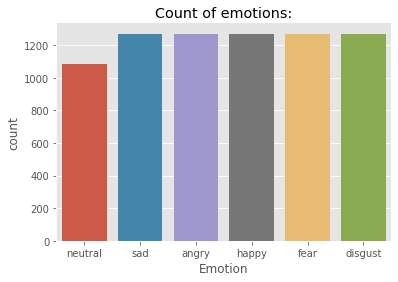

In [ ]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr, color="purple")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

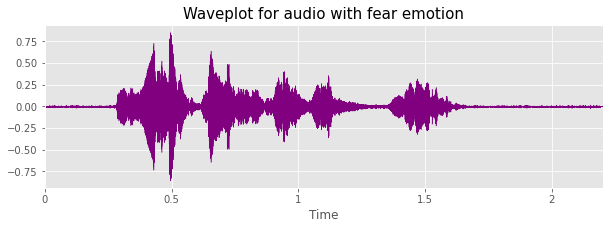

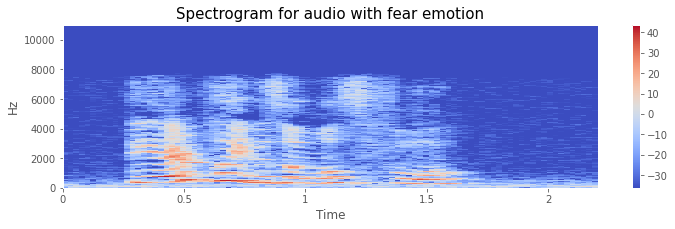

In [ ]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


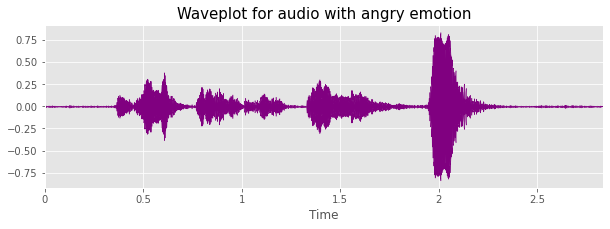

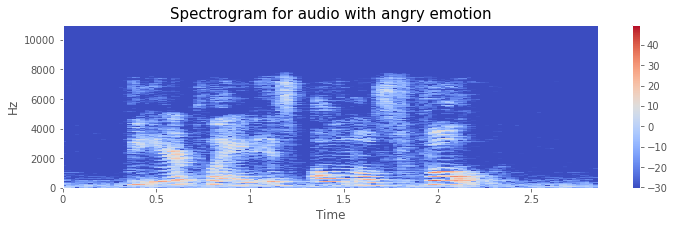

In [ ]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

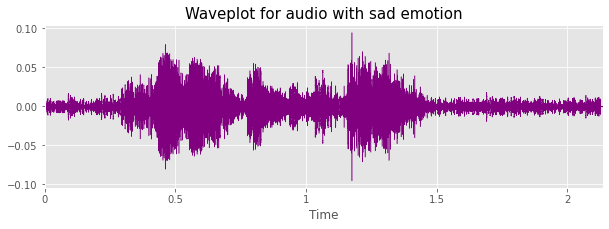

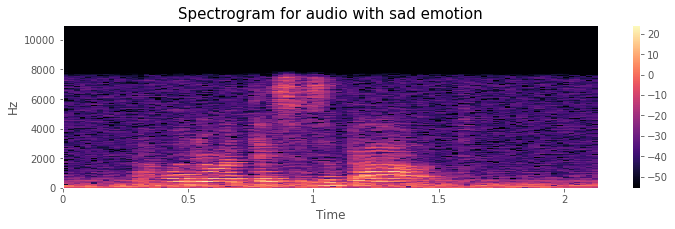

In [ ]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

There are lot of ways for data augmentation in sound data,
 we will use following in this project:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# Taking one sample from the dataset to check Data Augmentation techniques

path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple audio

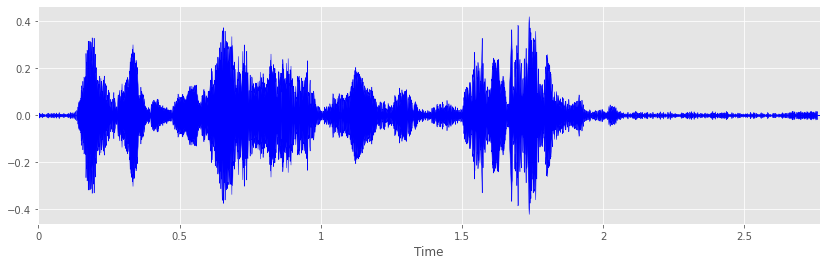

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate, color="blue")
Audio(path)

2. Noised audio

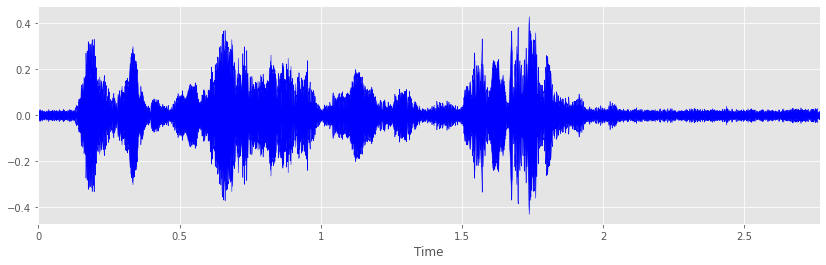

In [ ]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate, color="blue")
Audio(noised_data, rate=sampling_rate)


3. Stretching


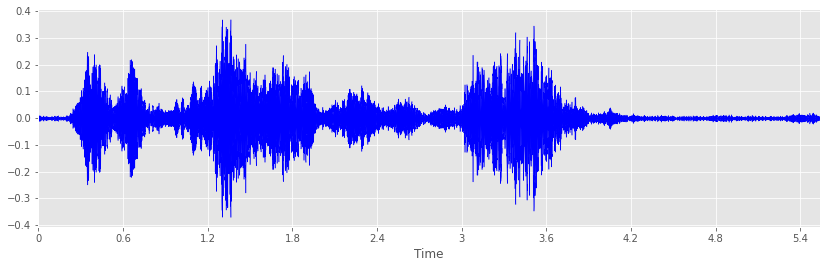

In [ ]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate, color="blue")
Audio(stretched_data, rate=sampling_rate)


4. Shifting


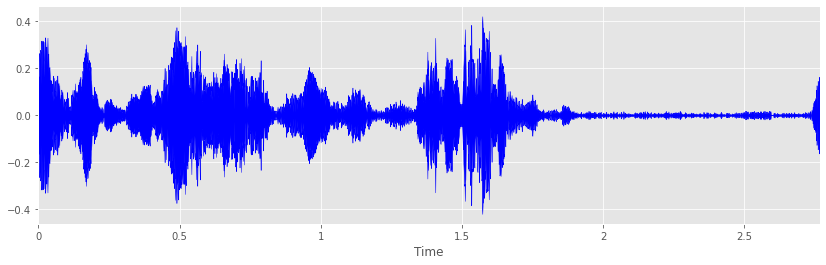

In [ ]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate, color="blue")
Audio(shifted_data, rate=sampling_rate)


5. Pitching

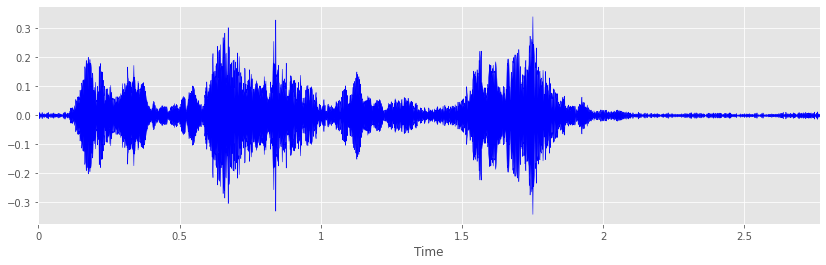

In [ ]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate,color="blue")
Audio(pitched_data, rate=sampling_rate)

For our dataset we will use noise, pitch and combination of both of them for Augmentation.


## Feature Extraction

Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

There are several data transormation methods with the help of sample rate and sample data are as follow:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [ ]:
n_fft = 2048
hop_length = 512

def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
# Taking one sample from the dataset to perform data tranformation techniques on it

path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

49308

In [ ]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (97,)
Energy:  (97,)
Entropy of Energy : (97,)
RMS : (97,)
Spectral Centroid : (97,)
Spectral Flux:  ()
Spectral Rollof:  (97,)
Chroma STFT:  (1164,)
MelSpectrogram:  (12416,)
MFCC:  (1940,)


In this project we will use 3 main Data Transformation features : 
*ZCR*, *RMS* and *MFCC*.

Also we will use just 2.5s duration with 0.6 offset.
In the dataset first 0.6s contains no information about emotion, and most of them are less then 3s.

In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [ ]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotion):
    features = get_features(path)
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

Let's save our Dataset as DataFrame for further processing:

In [ ]:
features_path = "features.csv"

In [ ]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)

In [ ]:
extracted_df = pd.read_csv("/content/drive/MyDrive/features.csv")
print(extracted_df.shape)

(29768, 2377)


In [ ]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(29768, 2377)

In [ ]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.033203,0.065430,0.110840,0.143066,0.137207,0.128906,0.100586,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.181152,0.295410,0.419922,0.434082,0.362793,0.286133,0.203125,0.174316,0.231934,0.248047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.035156,0.075195,0.121582,0.134277,0.130371,0.113281,0.083984,0.076660,0.068848,0.070312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.167480,0.278320,0.371582,0.368652,0.312012,0.235840,0.187988,0.183594,0.203613,0.211914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.129883,0.147461,0.148438,0.127930,0.073242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust


## Data Preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [ ]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [ ]:
# Encoding Emotion Labels with LabelEncoder()

lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# saving flattened format of LabelEncoder using pickle for further usage
filename = "Enc_labels.sav"
pickle.dump(lb,open(filename,"wb"))

In [ ]:
t_lb = pickle.load(open("Enc_labels.sav","rb"))
t_lb.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [ ]:
# Splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23814, 2376), (5954, 2376), (23814, 6), (5954, 6))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [ ]:
# Feature Scaling using Standard Scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [ ]:
scaling_Parameters = pd.DataFrame({"Mean":scaler.mean_, "Var":scaler.var_})
scaling_Parameters.to_csv("/content/drive/MyDrive/Scaling_Parameters_copy")

In [ ]:
# We have to use 1-dimensional CNN for which we need specific shape
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(21432, 2376, 1)

### Let's define our model:

In [ ]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 128)         196736    
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 128)        512       
 hNormalization)                                                 
                                                        

In [ ]:
EPOCHS = 20
batch_size = 32

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/20
670/670 [==============================] - 72s 87ms/step - loss: 1.6823 - acc: 0.3599 - val_loss: 1.4457 - val_acc: 0.4181 - lr: 0.0010
Epoch 2/20
670/670 [==============================] - 58s 87ms/step - loss: 1.3139 - acc: 0.4845 - val_loss: 1.5586 - val_acc: 0.4198 - lr: 0.0010
Epoch 3/20
670/670 [==============================] - 58s 87ms/step - loss: 1.0547 - acc: 0.6011 - val_loss: 1.3197 - val_acc: 0.4971 - lr: 0.0010
Epoch 4/20
670/670 [==============================] - 58s 87ms/step - loss: 0.7466 - acc: 0.7245 - val_loss: 1.2293 - val_acc: 0.5957 - lr: 0.0010
Epoch 5/20
670/670 [==============================] - 58s 87ms/step - loss: 0.4982 - acc: 0.8227 - val_loss: 0.8015 - val_acc: 0.7267 - lr: 0.0010
Epoch 6/20
670/670 [==============================] - 58s 86ms/step - loss: 0.3156 - acc: 0.8891 - val_loss: 1.1831 - val_acc: 0.6763 - lr: 0.0010
Epoch 7/20
670/670 [==============================] - 58s 86ms/step - loss: 0.2146 - acc: 0.9258 - val_loss: 0.9532 - 

187/187 [==============================] - 4s 23ms/step - loss: 0.5461 - acc: 0.8890
Accuracy of our model on test data :  88.89821767807007 %


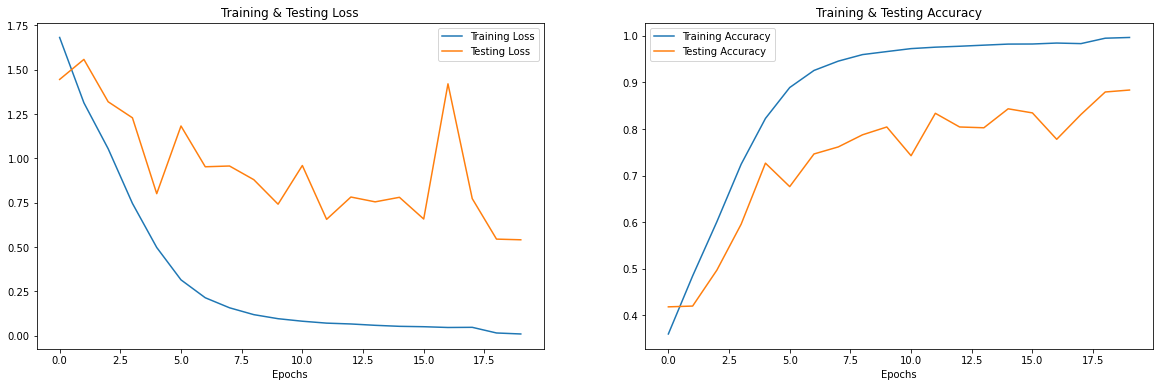

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred_class = [lb.classes_[idx] for idx in y_pred ]

In [ ]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class = [lb.classes_[idx] for idx in y_test_class ]

In [ ]:
result = pd.DataFrame({"Actual":y_test_class, "Predicted":y_pred_class})
result

,Actual,Predicted
0,angry,happy
1,happy,happy
2,disgust,disgust
3,angry,angry
4,disgust,disgust
...,...,...
5949,angry,fear
5950,neutral,neutral
5951,happy,happy
5952,happy,happy


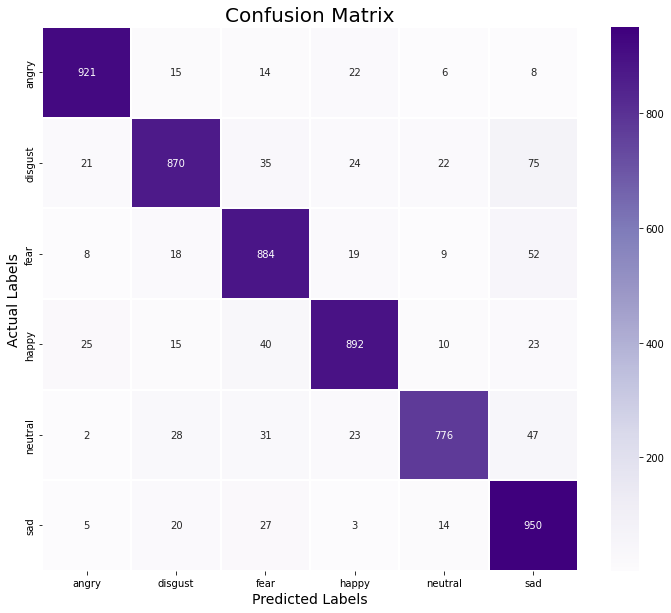

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

       angry       0.94      0.93      0.94       986
     disgust       0.90      0.83      0.86      1047
        fear       0.86      0.89      0.87       990
       happy       0.91      0.89      0.90      1005
     neutral       0.93      0.86      0.89       907
         sad       0.82      0.93      0.87      1019

    accuracy                           0.89      5954
   macro avg       0.89      0.89      0.89      5954
weighted avg       0.89      0.89      0.89      5954



In [ ]:
path_to_model = "/content/drive/MyDrive/SER_better_model.h5"
model.save(path_to_model)